In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math

In [2]:
df = pd.read_pickle('my_df.pkl')

In [3]:
df.head(10)

,Race,Number of Deaths,Population,Crude Death Rate,Age Adjusted Death Rate,Confidence Interval,Standard Error,year
0,American Indian or Alaska Native,"1,878","2,832,761",66.3,138.3,3.4,0.0%,1999
1,Asian or Pacific Islander,"8,976","11,346,496",79.1,125.4,1.4,0.1%,1999
2,Black or African American,"63,124","36,173,121",174.5,257.3,1.0,0.7%,1999
3,White,"489,087","228,687,790",213.9,202.9,0.3,5.6%,1999
4,American Indian or Alaska Native,"1,959","2,984,150",65.6,130.8,3.2,0.0%,2000
5,Asian or Pacific Islander,"9,415","11,757,685",80.1,124.7,1.4,0.1%,2000
6,Black or African American,"63,081","36,594,309",172.4,253.1,1.0,0.7%,2000
7,White,"492,182","230,085,762",213.9,202.2,0.3,5.7%,2000
8,American Indian or Alaska Native,"2,213","3,097,333",71.4,140.0,3.2,0.0%,2001
9,Asian or Pacific Islander,"9,992","12,429,181",80.4,122.7,1.3,0.1%,2001


In [4]:
df.isna().sum()

Race                       0
Number of Deaths           0
Population                 0
Crude Death Rate           0
Age Adjusted Death Rate    0
Confidence Interval        0
Standard Error             0
year                       0
dtype: int64

In [5]:
# remove capitals and replace spaces with underscores in column names
old_names = list(df.columns)
formatted_names = []
for name in old_names:
    name = str.lower(name)
    name = name.replace(' ', '_')
    formatted_names.append(name)

mapper = dict(zip(old_names, formatted_names))
df.rename(mapper = mapper, axis = 1, inplace = True)
df.head()

,race,number_of_deaths,population,crude_death_rate,age_adjusted_death_rate,confidence_interval,standard_error,year
0,American Indian or Alaska Native,"1,878","2,832,761",66.3,138.3,3.4,0.0%,1999
1,Asian or Pacific Islander,"8,976","11,346,496",79.1,125.4,1.4,0.1%,1999
2,Black or African American,"63,124","36,173,121",174.5,257.3,1.0,0.7%,1999
3,White,"489,087","228,687,790",213.9,202.9,0.3,5.6%,1999
4,American Indian or Alaska Native,"1,959","2,984,150",65.6,130.8,3.2,0.0%,2000


In [6]:
df.dtypes

race                       object
number_of_deaths           object
population                 object
crude_death_rate           object
age_adjusted_death_rate    object
confidence_interval        object
standard_error             object
year                       object
dtype: object

In [7]:
# format data to numeric type where appropriate
df = df.apply(lambda x: x.str.replace(',',''))
columns = list(df.columns)
for column in columns:
    df[column] = pd.to_numeric(df[column], errors = 'ignore')
df.head()

,race,number_of_deaths,population,crude_death_rate,age_adjusted_death_rate,confidence_interval,standard_error,year
0,American Indian or Alaska Native,1878,2832761,66.3,138.3,3.4,0.0%,1999
1,Asian or Pacific Islander,8976,11346496,79.1,125.4,1.4,0.1%,1999
2,Black or African American,63124,36173121,174.5,257.3,1.0,0.7%,1999
3,White,489087,228687790,213.9,202.9,0.3,5.6%,1999
4,American Indian or Alaska Native,1959,2984150,65.6,130.8,3.2,0.0%,2000


In [8]:
df.dtypes

race                        object
number_of_deaths             int64
population                   int64
crude_death_rate           float64
age_adjusted_death_rate    float64
confidence_interval        float64
standard_error              object
year                         int64
dtype: object

In [9]:
# add column for death rate as ordinary percentage
df['death_rate'] = df['crude_death_rate'] / 1000

In [10]:
# see mean death rate grouped by race over whole time period
racial_death_rate = df[['race', 'death_rate']].groupby('race').mean()
racial_death_rate.sort_values(by = 'death_rate', ascending = False)

,death_rate
race,
White,0.207947
Black or African American,0.163773
Asian or Pacific Islander,0.081980
American Indian or Alaska Native,0.068773


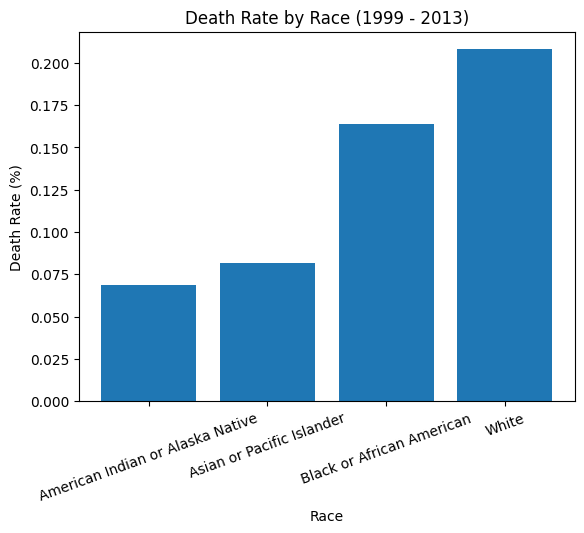

In [11]:
# visually see mean death rate grouped by race over whole time period
plt.bar(x = racial_death_rate.index, height = racial_death_rate['death_rate'])
plt.xticks(rotation = 20)
plt.title('Death Rate by Race (1999 - 2013)')
plt.ylabel('Death Rate (%)')
plt.xlabel('Race')
plt.show()

In [12]:
racial_death_rate['death_rate'].max() - racial_death_rate['death_rate'].min()

0.13917333333333332

From the above bar graph we can see that the White racial group has the highest proportional death rate from cancer over the whole time period compared to all the other races. Both the White and Black or African American racial groups have a much higher death rate than the American Indian or Alaskan Native and Asian or Pacific Islander, a difference of 0.08%. The overall range of proportional deathrates was only about 0.14%, so the deathrates for each race really doesn't differ by much. So is the difference in deathrate statistically significant? Does at least one of these racial groups actually die from cancer more often than the others, or is the observed difference in this sample just due to the nature of random variability? We would like to perform an ANOVA test to see if there is a statistical difference in the death rates between the racial groups.

### Racial Death Rate ANOVA

H0: There is no difference among the death rates for each racial group.

H<sub>a</sub>: There is a difference in at least one of the racial death rates. 

Three conditions for an ANOVA test need to be established, independence of observations, normality, and homogeneity of variances. We explore these conditions.

1. Independence of observations: It is not at all clearly the case that these racial groups are necessesarily independent. We know an individual can bear membership to more than one racial group, and even if, for the purposes of a study, a researcher wanted these groups to be exclusive, we don't know if that was established in this particular dataset. Someone who is 50/50 mixed racial heritage may choose to identify as one or the other or both. Each choice makes a difference for the sake of independence of observations, and the last choice would seem to exclude that individual from the study altogether. For the sake of this exercise and its pedagogical value, we will continue investigating the other criteria. 
2. Normality: Below we use a one sample Kolmogorov-Smirnov test on each of the racial group's cancer death rates to establish normality. This test compares the empirical cumulative distribution function of a passed dataset to a specified theoretical cumulative distribution function. The test's null hypothesis is that the sample distribution passed into the function (death rate of a race) is equal to the specified theoretical distribution (the normal distribution in this case).
3. Variance: The variances of the group levels need to be equal, or more realistically just reasonably similar. To establish this we will perform an F-test. which is simply to look at the ratio of the variances between the group with the smallest sample size, and the group with the largest sample size. If the f-score is close to one, it is assumed that these populations have equal variances. 


WELL ANOVA FAILED, DATA HAS UNEQUAL VARIANCES. NEXT TIME ON DRAGONBALL Z, WE TRY THE WELCH'S T-TEST

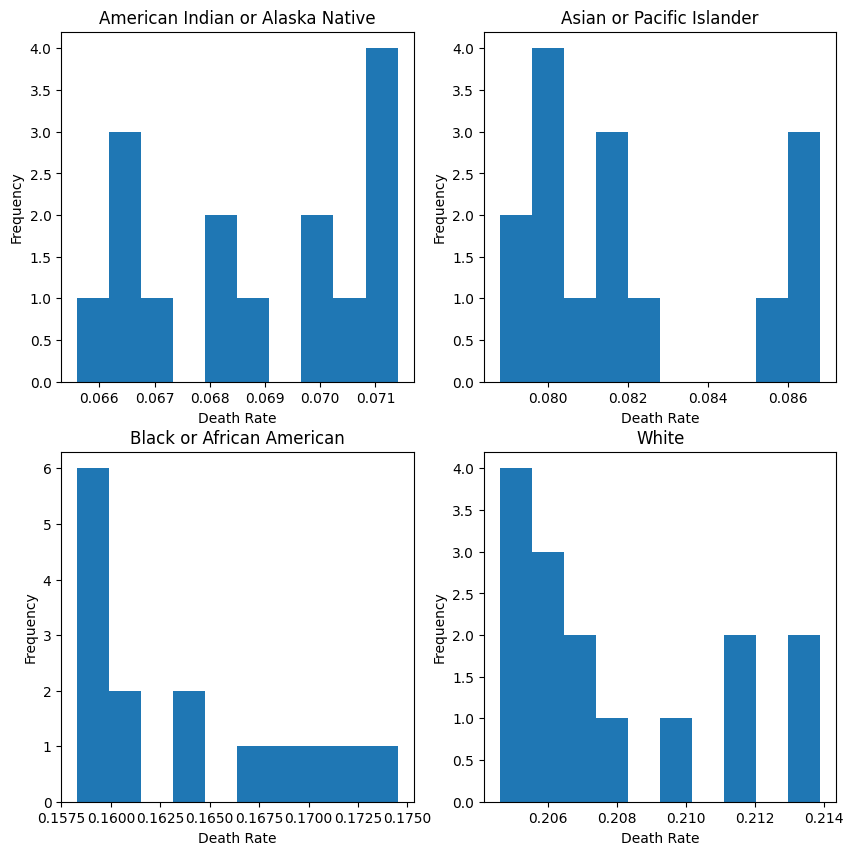

In [13]:
# Before performing any tests, let's avail ourselves of the simplest most tried and true method for assessing the shape of a sample's distribution: just look at the histograms!
races = df['race'].unique()
n = len(races)
cols = 2
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
for i, race in enumerate(races):
    ax = axs[i // cols, i % cols]
    
    ax.hist(df[df['race'] == race]['death_rate'], bins = 10)
    ax.set_title(race)
    # Set labels for x and y axes
    ax.set_xlabel('Death Rate')
    ax.set_ylabel('Frequency')

These historgrams aren't promising, none of them look very normal. But remember, these histograms are made out of the deathrates of each race over the whole time period (1999 - 2013), and that time period is only 15 years long. There are only 15 data points in each histogram. With such small sample sizes, it's pretty easy to end up with wacky shapes that don't conform to nice distributions. On to the KS test.

### Kolmogorov-Smirnov test for Normality

The Kolmogorov-Smirnov (KS) test compares the cumulative distribution function (CDF) of a passed dataset (your sample) to a specified theoretical CDF. If the CDF's are the same, then the distributions are the same, and so the functions describing those distributions are the same. It results in a statistic, D, which is simply the maximum absolute vertical distance between the sample's CDF and the theoretical  distribution's CDF.

- H0: The sample distribution is normally distributed. F<sub>S</sub>(x) = F<sub>T</sub>(x)
- H<sub>a</sub>: The sample distribution is not normally distributed. F<sub>S</sub>(x) =/= F<sub>T</sub>(x)
- Level of Significance: 0.05

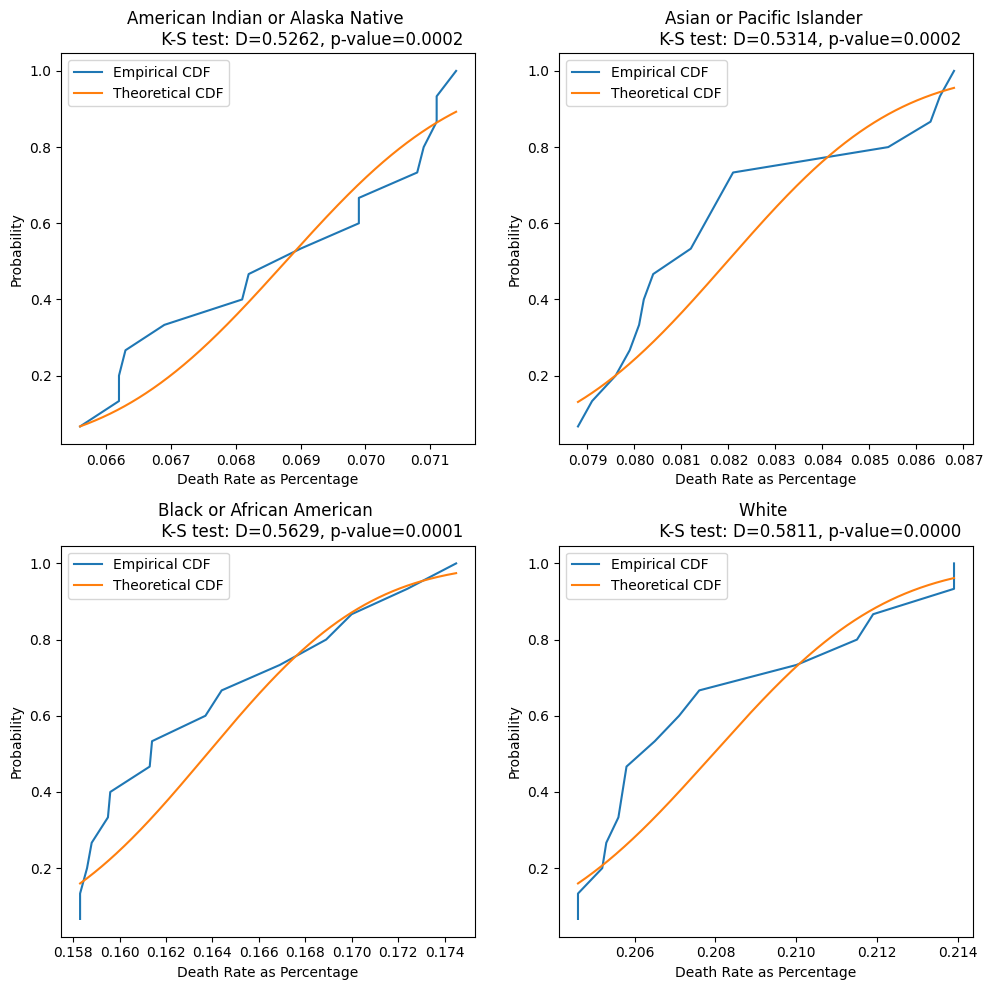

In [15]:
# Kolmogorov-Smirnov test to test for normality

# Isolate groups, as a KS test is done for each racial group, and get some rows and columns for matplotlib grid
races = df['race'].unique()
n = len(races)
cols = 2
rows = math.ceil(n / cols)

# We'd like to visualize all four KS tests for each race
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))


for i, race in enumerate(races):
    ax = axs[i // cols, i % cols]

    sample = df[df['race'] == race]['death_rate'] # sample constitutes the race being KS tested through each iteration

    # Perform the K-S test against a normal distribution. At this point the test is done, the rest is for visualization purposes
    d, p_value = stats.kstest(sample, 'norm')

    # Assemble sample CDFs
    x = np.sort(sample) # Need sorted data for CDF
    y = np.arange(1, len(sample)+1) / len(sample)  # Each data point is 1 out of the 15 data points. The proportion of each datum's index out of the length of the list gives the cumulative proportion [1/15, 2/15,..., 15/15]

    # Assemble the theoretical CDFs
    x_theoretical = np.linspace(min(x), max(x), 1000) # Simulate continuous distribution within the sample's domain
    y_theoretical = stats.norm.cdf(x_theoretical, sample.mean(), sample.std())  # Use norm.cdf function to generate theoretical CDF, centered on sample's statistics

    # Plot both CDFs for comparison
    ax.plot(x, y, label='Empirical CDF')
    ax.plot(x_theoretical, y_theoretical, label='Theoretical CDF')
    ax.set_title(f'''{race} 
                 K-S test: D={d:.4f}, p-value={p_value:.4f}''')
    ax.legend()
    # Set labels for x and y axes
    ax.set_xlabel('Death Rate as Percentage')
    ax.set_ylabel('Probability')

# Remove empty subplots
if n % cols != 0:
    for j in range(i+1, rows*cols):
        fig.delaxes(axs.flatten()[j])



plt.tight_layout()
plt.show()

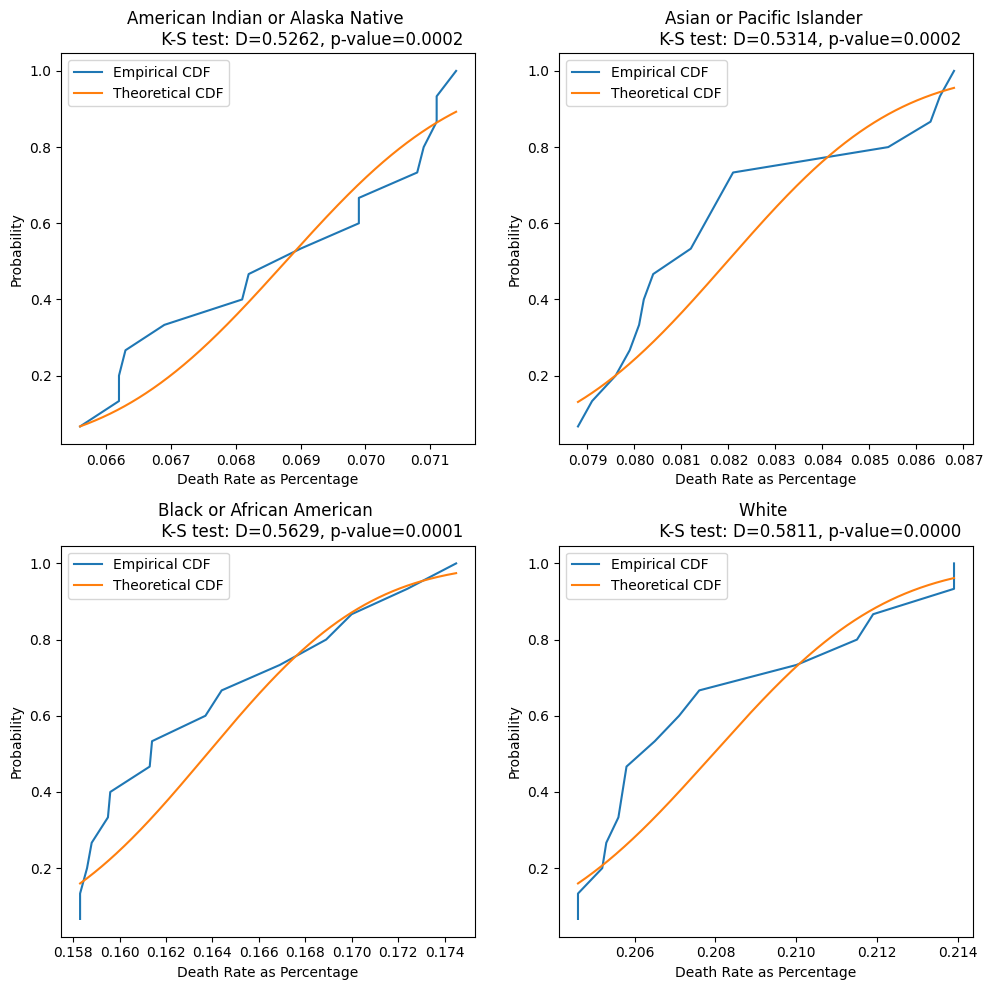

In [ ]:
# Kolmogorov-Smirnov test to test for normality

races = df['race'].unique()
n = len(races)
cols = 2
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
for i, race in enumerate(races):
    ax = axs[i // cols, i % cols]

    sample = df[df['race'] == race]['death_rate']
    mean = sample.mean()
    std = sample.std()

    # Perform the K-S test against a normal distribution
    d, p_value = stats.kstest(sample, 'norm')

    # Calculate the CDFs
    x = np.sort(sample)
    y = np.arange(1, len(sample)+1) / len(sample)  # Scale y-axis to be between 0 and 1 to represent probability for empirical CDF

    x_theoretical = np.linspace(min(x), max(x), 1000) # Simulate continuous distribution of sample data
    cdf_theoretical = stats.norm.cdf(x_theoretical, mean, std)  # Use norm.cdf function to generate theoretical CDF, centered on sample's statistics

    # Plot both CDFs for comparison
    ax.plot(x, y, label='Empirical CDF')
    ax.plot(x_theoretical, cdf_theoretical, label='Theoretical CDF')
    ax.set_title(f'''{race} 
                 K-S test: D={d:.4f}, p-value={p_value:.4f}''')
    ax.legend()
    # Set labels for x and y axes
    ax.set_xlabel('Death Rate as Percentage')
    ax.set_ylabel('Probability')

# Remove empty subplots
if n % cols != 0:
    for j in range(i+1, rows*cols):
        fig.delaxes(axs.flatten()[j])



plt.tight_layout()
plt.show()

In [ ]:
df.head(10)

,race,number_of_deaths,population,crude_death_rate,age_adjusted_death_rate,confidence_interval,standard_error,year,death_rate
0,American Indian or Alaska Native,1878,2832761,66.3,138.3,3.4,0.0%,1999,0.0663
1,Asian or Pacific Islander,8976,11346496,79.1,125.4,1.4,0.1%,1999,0.0791
2,Black or African American,63124,36173121,174.5,257.3,1.0,0.7%,1999,0.1745
3,White,489087,228687790,213.9,202.9,0.3,5.6%,1999,0.2139
4,American Indian or Alaska Native,1959,2984150,65.6,130.8,3.2,0.0%,2000,0.0656
5,Asian or Pacific Islander,9415,11757685,80.1,124.7,1.4,0.1%,2000,0.0801
6,Black or African American,63081,36594309,172.4,253.1,1.0,0.7%,2000,0.1724
7,White,492182,230085762,213.9,202.2,0.3,5.7%,2000,0.2139
8,American Indian or Alaska Native,2213,3097333,71.4,140.0,3.2,0.0%,2001,0.0714
9,Asian or Pacific Islander,9992,12429181,80.4,122.7,1.3,0.1%,2001,0.0804


In [ ]:
df.columns

Index(['race', 'number_of_deaths', 'population', 'crude_death_rate',
       'age_adjusted_death_rate', 'confidence_interval', 'standard_error',
       'year', 'death_rate'],
      dtype='object')

In [ ]:
group1 = df[df['race'] == 'White']['death_rate']
group2 = df[df['race'] == 'Black or African American']['death_rate']

len(group1)

15

In [ ]:
# Assuming you have two groups you want to compare, represented as NumPy arrays or pandas Series:
groups = []
for race in df['race'].unique():
    groups.append(df[df['race'] == race]['death_rate'])

# Calculate variance
variances = []
for group in groups:
    variances.append(np.var(group))  # Variance of each group


# Calculate F test statistic
f_test_stat = max(variances) / min(variances)  # F test statistic

# Calculate degrees of freedom for each group
dof = len(df['year'].unique()) - 1  # degrees of freedom for group 1

# Calculate critical value at 5% level
alpha = 0.05  # significance level
f_critical_1 = stats.f.ppf(alpha / 2, dof, dof)  # left critical value
f_critical_2 = stats.f.ppf(1 - alpha / 2, dof, dof)  # right critical value

# Calculate p-value
p_value = 2 * min(stats.f.cdf(f_test_stat, dof, dof), 1 - stats.f.cdf(f_test_stat, dof, dof))

# Print results
print(f'F Test Statistic: {f_test_stat}')
print(f'F Critical Value: {f_critical_1, f_critical_2}')
print(f'P-Value: {p_value}')

F Test Statistic: 6.758478362622848
F Critical Value: (0.33572960066081176, 2.97858752410188)
P-Value: 0.000993157112632037


In [ ]:
# Take a look at variance to see if they're equal

variances = []
for race in df['race'].unique():
    variances.append(df[df['race'] == race]['death_rate'].std())
var_ratio = max(variances) / min(variances)
var_ratio

2.5997073609587003

In [ ]:
# see death rate of all races aggregated over the time period
death_rate_over_time = df[['year', 'death_rate']].groupby('year').mean()
death_rate_over_time

,death_rate
year,
1999,0.133450
2000,0.133000
2001,0.133425
2002,0.132050
2003,0.130750
2004,0.130550
2005,0.130900
2006,0.129050
2007,0.129100


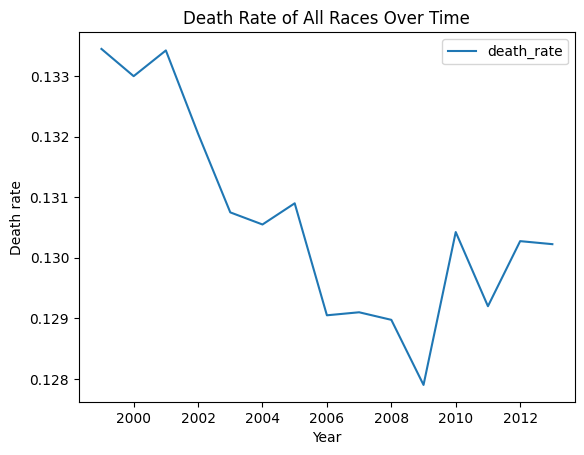

In [ ]:
death_rate_over_time.plot(xlabel="Year", ylabel="Death rate", title = 'Death Rate of All Races Over Time')
plt.show()

The mean death rate of all races over the time period seems to have a downward trend between the years of 1999 and 2009, after which it looks like it picks back up. 

Let's look at a linear regression t test to see if time and cancer deaths are linearly related. While the graphs strongly suggest an inverse relationship between time and death rate, at least between the years of 1999 and 2009, we have a hunch that cancer death rates are actually going up. Therefore we will perform a two sided t test, and not specify the direction of the linear relationship in our alternative hypothesis.

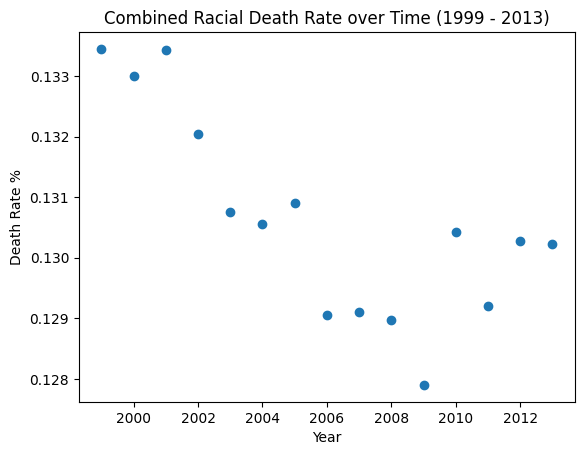

In [ ]:
plt.scatter(x = death_rate_over_time.index, y = death_rate_over_time['death_rate'])
plt.title('Combined Racial Death Rate over Time (1999 - 2013)')
plt.ylabel('Death Rate %')
plt.xlabel('Year')
plt.show()

In [ ]:
# H0: There is no linear relationship between time and cancer death rate.
# HA: There is a linear relationship between time and cancer death rate.



In [ ]:
df['race'].unique()

array(['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'White'], dtype=object)

In [ ]:
# look at the death rate over time for each race separately
racial_dr_over_time = pd.DataFrame(index = range(len(df['year'].unique())))

for race in df['race'].unique():
    racial_dr_over_time[race] = df[df['race'] == race]['death_rate'].reset_index(drop = True)
racial_dr_over_time.set_index(df['year'].unique(), inplace = True)
racial_dr_over_time

,American Indian or Alaska Native,Asian or Pacific Islander,Black or African American,White
1999,0.0663,0.0791,0.1745,0.2139
2000,0.0656,0.0801,0.1724,0.2139
2001,0.0714,0.0804,0.1700,0.2119
2002,0.0690,0.0788,0.1689,0.2115
2003,0.0662,0.0799,0.1669,0.2100
2004,0.0711,0.0796,0.1644,0.2071
2005,0.0708,0.0815,0.1637,0.2076
2006,0.0681,0.0802,0.1614,0.2065
2007,0.0682,0.0812,0.1613,0.2057
2008,0.0699,0.0821,0.1586,0.2053


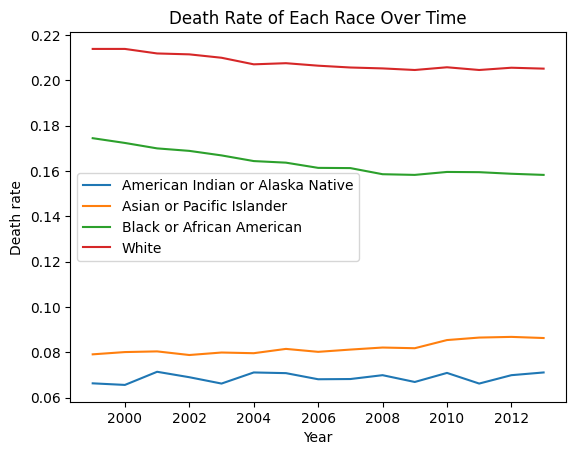

In [ ]:
racial_dr_over_time.plot(xlabel="Year", ylabel="Death rate", title = 'Death Rate of Each Race Over Time')
plt.show()

Seeing how each race's death rate varies over time clarifies the combined racial death rate a little bit. Curiously, the White and Black or African American death rates have gone down, while the Asian or Pacific islander and American Indian or Alaska Native death rates have gone up. Again, the increase or decrease in death rate is quite small, only fractions of a percent.

# 